<a href="https://colab.research.google.com/github/reemahmed123/ML_Project/blob/main/beforeFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import os
import shutil

zip_path = "/content/dataset.zip"
extract_to = "/content/raw_temp"

if os.path.exists(extract_to):
    shutil.rmtree(extract_to)

print(f" Unzipping {zip_path}...")
!unzip -q "{zip_path}" -d "{extract_to}"
print(" Done unzipping.")


 Unzipping /content/dataset.zip...
 Done unzipping.


In [ ]:
#import shutil

#shutil.rmtree("/content/data/processed_dataset")


In [44]:
!wget -q https://raw.githubusercontent.com/Fatimah3844/ML_Project/main/dataset.zip

In [45]:
!ls

data			     __pycache__
dataset.zip		     raw_temp
knn_material_classifier.pkl  sample_data
processed_data_final.zip     svm_material_classifier.pkl


In [46]:

import os

file_path = "/content/dataset.zip"

if os.path.exists(file_path):
    size_bytes = os.path.getsize(file_path)
    size_mb = size_bytes / (1024 * 1024)
    print(f" File: {file_path}")
    print(f" Size: {size_mb:.2f} MB")

    if size_mb < 0.1:
        print("\n download field .")
    else:
        print("\n size .")
else:
    print(" file does not exsist")


 File: /content/dataset.zip
 Size: 213.84 MB

 size .


In [47]:

import os
import cv2
import shutil
import random
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# --- Reproducibility Setup ---
# Setting a seed ensures that the train/test split is the same every time we run the code.
SEED_VAL = 42
random.seed(SEED_VAL)
np.random.seed(SEED_VAL)

# --- Paths & Config ---
raw_source_dir = "/content/raw_temp"
processed_dest_dir = "/content/processed_dataset"
final_img_size = (224, 224)
aug_factor = 2  # Number of augmented copies per image

# Project Classes
target_labels = ["glass", "paper", "cardboard", "plastic", "metal", "trash", "unknown"]

def generate_augmentations(img):
    """
    Apply random transformations: Flip, Rotate, Zoom, Brightness, Blur.
    Used to increase the training set size.
    """
    aug_results = []
    h, w = img.shape[:2]

    for _ in range(aug_factor):
        curr_img = img.copy()
        mod_flag = False

        # 1. Flip
        # Increased probability to 50%
        if random.random() > 0.5:
            code = random.choice([1, 0, -1])
            curr_img = cv2.flip(curr_img, code)
            mod_flag = True

        # 2. Rotation
        # Keep probability at 30% to avoid too many twisted images
        if random.random() > 0.7:  # Adjusted threshold
            angle = random.choice([random.randint(-30, -10), random.randint(10, 30)])
            center = (int(w / 2), int(h / 2))
            M = cv2.getRotationMatrix2D(center, angle, 1.0)
            curr_img = cv2.warpAffine(curr_img, M, (w, h), borderMode=cv2.BORDER_REFLECT)
            mod_flag = True

        # 3. Zoom (Crop & Resize)
        # Probability 40%
        if random.random() > 0.6:
            # Zoom range 20% to 40%
            scale = random.uniform(1.2, 1.4)

            new_h, new_w = int(h / scale), int(w / scale)
            start_y = (h - new_h) // 2
            start_x = (w - new_w) // 2

            curr_img = curr_img[start_y:start_y+new_h, start_x:start_x+new_w]
            curr_img = cv2.resize(curr_img, (w, h))
            mod_flag = True

        # 4. Brightness
        # Probability 40%
        if random.random() > 0.6:
            alpha = random.uniform(0.8, 1.2) # Contrast
            beta = random.randint(-30, 30)   # Brightness
            curr_img = cv2.convertScaleAbs(curr_img, alpha=alpha, beta=beta)
            mod_flag = True

        # 5. Blur
        # Lower probability (20%) because too much blur is bad
        if random.random() > 0.8:
            curr_img = cv2.GaussianBlur(curr_img, (5, 5), 0)
            mod_flag = True

        # Ensure at least one change happens
        if not mod_flag:
            curr_img = cv2.flip(curr_img, 1)

        aug_results.append(curr_img)

    return aug_results

# --- Main Execution ---

print("Student 1 Pipeline: Starting Data Preparation...")

# finding folders
found_folders = {}

for root, dirs, files in os.walk(raw_source_dir):
    for d in dirs:
        d_name = d.lower()
        for lbl in target_labels:
            if lbl in d_name and lbl not in found_folders:
                full_p = os.path.join(root, d)
                if len(os.listdir(full_p)) > 0:
                    found_folders[lbl] = full_p

if not found_folders:
    print("Error: No class folders found in zip.")
else:
    # Reset output directory
    if os.path.exists(processed_dest_dir):
        shutil.rmtree(processed_dest_dir)

    print(f"Found {len(found_folders)} classes. Processing...")

    for lbl, src_path in found_folders.items():
        # Naming convention: 0_Glass, 1_Paper, etc.
        idx = target_labels.index(lbl)
        folder_name = f"{idx}_{lbl.capitalize()}"

        # Create directories
        os.makedirs(os.path.join(processed_dest_dir, "train", folder_name), exist_ok=True)
        os.makedirs(os.path.join(processed_dest_dir, "val", folder_name), exist_ok=True)

        # Collect images
        valid_exts = ('.jpg', '.jpeg', '.png')
        files_list = [f for f in os.listdir(src_path) if f.lower().endswith(valid_exts)]

        if not files_list: continue

        # Split (80/20)
        train_files, val_files = train_test_split(files_list, test_size=0.2, random_state=SEED_VAL)

        # 1. Handle Training Data (with Augmentation)
        for f in tqdm(train_files, desc=f"Train: {folder_name}"):
            img = cv2.imread(os.path.join(src_path, f))
            if img is None: continue

            # Resize
            img = cv2.resize(img, final_img_size)

            # Save original
            cv2.imwrite(os.path.join(processed_dest_dir, "train", folder_name, f), img)

            # Save augmented
            try:
                augmented_list = generate_augmentations(img)
                for i, aug_img in enumerate(augmented_list):
                    aug_name = f"aug_{i}_{f}"
                    cv2.imwrite(os.path.join(processed_dest_dir, "train", folder_name, aug_name), aug_img)
            except:
                pass

        # 2. Handle Validation Data (No Augmentation)
        for f in val_files:
            img = cv2.imread(os.path.join(src_path, f))
            if img is None: continue

            img = cv2.resize(img, final_img_size)
            cv2.imwrite(os.path.join(processed_dest_dir, "val", folder_name, f), img)

    # Final Step: Zip
    print("\nCreating final zip file...")
    shutil.make_archive("/content/processed_data_final", 'zip', processed_dest_dir)
    print("Done, Download 'processed_data_final.zip'.")


Student 1 Pipeline: Starting Data Preparation...
Found 7 classes. Processing...


Train: 5_Trash: 100%|██████████| 88/88 [00:00<00:00, 379.13it/s]



Creating final zip file...
Done, Download 'processed_data_final.zip'.


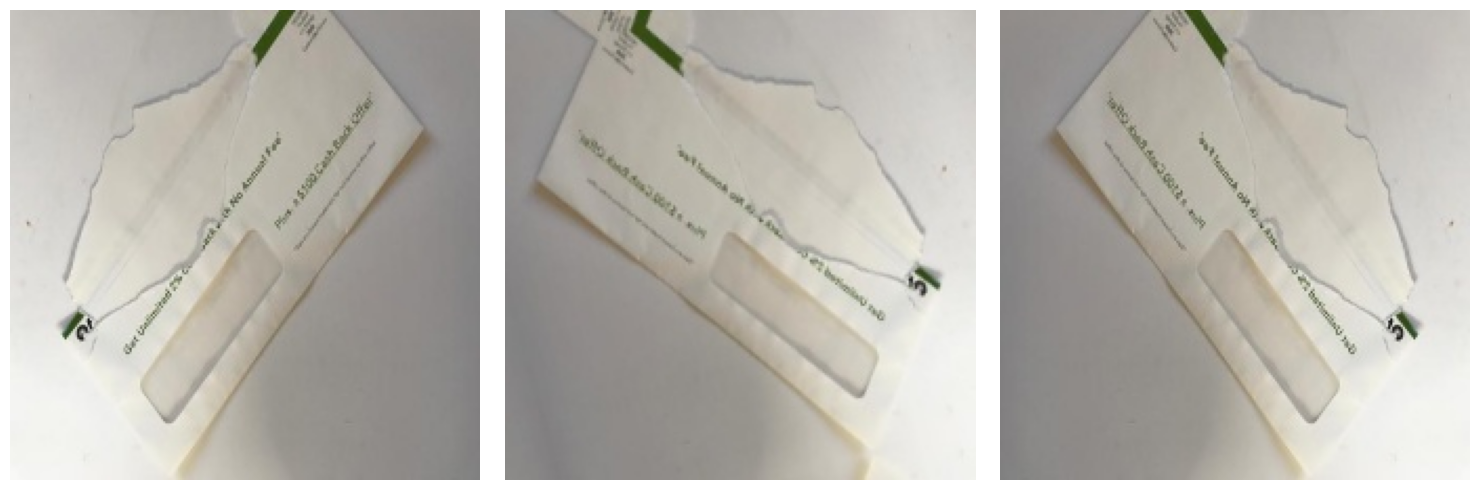

  7da42de8-3e1f-4c38-bb00-6a6e1fa536b2.jpg
 2 agumented copies


In [48]:
## this code is just for showing the result of augumentation
import matplotlib.pyplot as plt
import cv2
import os
import random

PROCESSED_PATH = "/content/processed_dataset/train"
CLASS_NAME = "1_Paper"

folder_path = os.path.join(PROCESSED_PATH, CLASS_NAME)
if not os.path.exists(folder_path):
    found = [d for d in os.listdir(PROCESSED_PATH) if "cardboard" in d.lower()]
    if found:
        folder_path = os.path.join(PROCESSED_PATH, found[0])
        CLASS_NAME = found[0]

files = os.listdir(folder_path)


aug_files = [f for f in files if f.startswith("aug_")]
orig_files = [f for f in files if not f.startswith("aug_")]

if not orig_files:
    print("nothing")
else:
    random_orig = random.choice(orig_files)

    related_augs = [f for f in aug_files if f.endswith(random_orig)]

    plt.figure(figsize=(15, 5))

    img_path = os.path.join(folder_path, random_orig)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(1, len(related_augs) + 1, 1)
    plt.imshow(img)
    plt.axis('off')

    for i, aug_name in enumerate(related_augs):
        aug_path = os.path.join(folder_path, aug_name)
        aug_img = cv2.imread(aug_path)
        aug_img = cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, len(related_augs) + 1, i + 2)
        plt.imshow(aug_img)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    print(f"  {random_orig}")
    print(f" {len(related_augs)} agumented copies")


In [49]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


In [50]:
PROJECT_ROOT = os.getcwd()
processed_dataset_dir = os.path.join(PROJECT_ROOT,"data", "processed_dataset")
train_dir = os.path.join(processed_dataset_dir, "train")

classes = [
    "0_Glass",
    "1_Paper",
    "2_Cardboard",
    "3_Plastic",
    "4_Metal",
    "5_Trash",
    "6_Unknown"
]


In [51]:
base_model = ResNet50(
    weights="imagenet",
    include_top=False,   # ❗ remove classification head
    pooling="avg",       # global average pooling
    input_shape=(224, 224, 3)
)

model = Model(inputs=base_model.input, outputs=base_model.output)

print("CNN feature size:", model.output_shape)


CNN feature size: (None, 2048)


In [52]:
def load_and_preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img


In [53]:
def extract_cnn_features(img_path):
    img = load_and_preprocess_image(img_path)
    features = model.predict(img, verbose=0)
    return features.flatten()


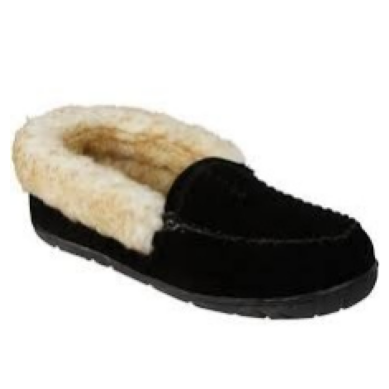

In [54]:
sample_class = "6_Unknown"
sample_folder = os.path.join(train_dir, sample_class)
sample_img = os.listdir(sample_folder)[0]

img = cv2.imread(os.path.join(sample_folder, sample_img))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis("off")
plt.show()


In [55]:
X = []
y = []

for class_name in classes:
    folder = os.path.join(train_dir, class_name)

    for f in os.listdir(folder):
        if not f.lower().endswith(".jpg"):
            continue

        img_path = os.path.join(folder, f)
        feat = extract_cnn_features(img_path)

        X.append(feat)
        y.append(class_name)

X = np.array(X)
y = np.array(y)

print("Number of samples:", X.shape[0])
print("Feature vector length:", X.shape[1])


Number of samples: 4764
Feature vector length: 2048


In [56]:
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [57]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# k-NN محسّن مع weighting scheme وk=5
knn = KNeighborsClassifier(n_neighbors=5, weights="distance", metric="euclidean")
knn.fit(X_tr, y_tr)

y_pred_knn = knn.predict(X_val)
print("k-NN Validation accuracy:", accuracy_score(y_val, y_pred_knn))


k-NN Validation accuracy: 0.9611752360965372


In [58]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Pipeline مع StandardScaler + SVM
svm_model = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf", C=10, gamma="scale", probability=True))
])

svm_model.fit(X_tr, y_tr)
y_pred_svm = svm_model.predict(X_val)
print("SVM Validation accuracy:", accuracy_score(y_val, y_pred_svm))


SVM Validation accuracy: 0.9863588667366212


In [39]:
import joblib

joblib.dump(knn, "knn_material_classifier.pkl")
joblib.dump(svm_model, "svm_material_classifier.pkl")
print("Models saved successfully!")


Models saved successfully!
